<a href="https://colab.research.google.com/github/devrayat000/dl_workspace/blob/master/3_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
print(f"Notebook last run (end - to - end):{datetime.datetime.now()}")

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL

Notebook last run (end - to - end):2024-11-14 09:49:11.597673


2024-11-14 09:49:12.159977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731556152.238594  299971 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731556152.262010  299971 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 09:49:12.424341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Downloading Data

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"
# Get the zip file from the URL and extract it
data_dir = tf.keras.utils.get_file('pizza_steak.zip', cache_dir="./", origin=dataset_url, extract=True)
# remove the file suffix
data_dir = pathlib.Path(data_dir).with_suffix('')

Inspecting the data

In [ ]:
# Move into the "pizza_steak" directory
data_dir = data_dir/"pizza_steak"
print(data_dir)

datasets/pizza_steak_extracted/pizza_steak


In [ ]:
# List all .jpg files in the directory
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

2000


Viewing an image

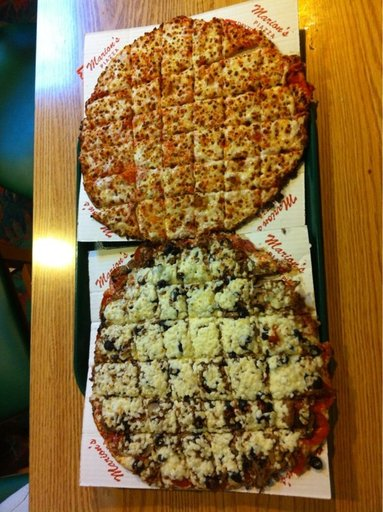

In [ ]:
# View the first pizza from the training directory
pizzas = list(data_dir.glob('train/pizza/*'))
PIL.Image.open(str(pizzas[0]))

## Creating a convolutional neural network to train our data within a model

Define some parameters for the loader

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Define training and testing directories
train_dir = data_dir/'train'
test_dir = data_dir/'test'
train_dir, test_dir

(PosixPath('datasets/pizza_steak_extracted/pizza_steak/train'),
 PosixPath('datasets/pizza_steak_extracted/pizza_steak/test'))

In [ ]:
# Create a training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=42
)

Found 1500 files belonging to 2 classes.


I0000 00:00:1731556762.918667  299971 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
# Create a validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=42
)

Found 500 files belonging to 2 classes.


In [ ]:
# Get the class names of the images
class_names = train_ds.class_names
print(class_names)

['pizza', 'steak']


### Visualizing the data

Display random 9 images

2024-11-14 10:01:44.533547: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


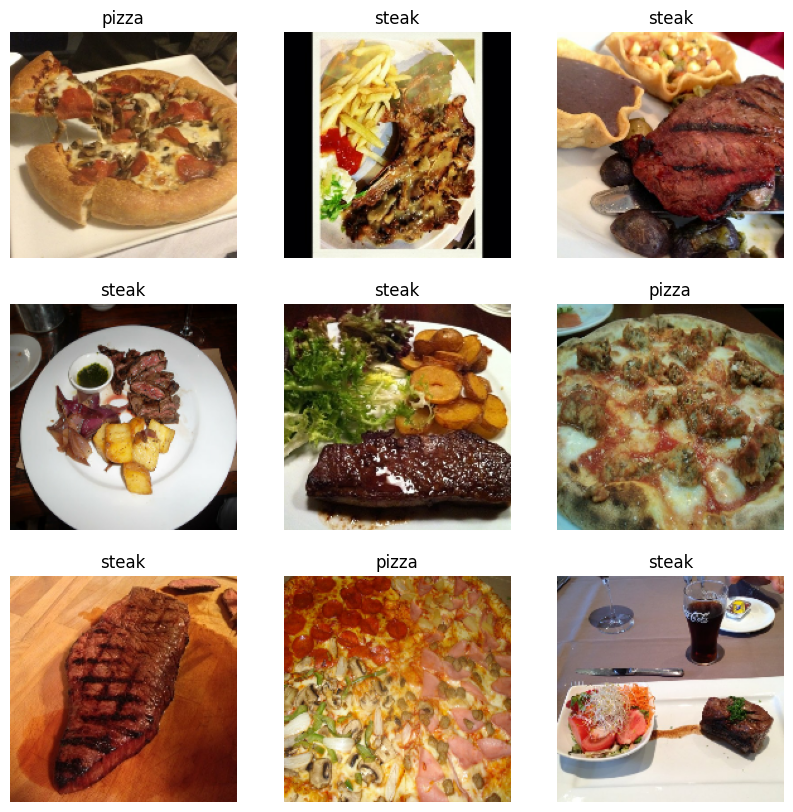

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  # Plot the first 9 random images
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Print data structures

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Cache the dataset for performance

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model_1 = tf.keras.Sequential([
    # Rescale the color channel values from 0-255 to 0-1
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compiling the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 176, 176, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 88, 88, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 86, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 84, 84, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17640)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        17,641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,651 (80.67 KB)

 Trainable params: 20,651 (80.67 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 10

# Fitting the model
history_1 = model_1.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs)

Epoch 1/10


I0000 00:00:1731557455.508208  301305 service.cc:148] XLA service 0x778800004c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731557455.508328  301305 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-14 10:10:55.597783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731557455.904836  301305 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-14 10:10:59.193032: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 0

47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.6006 - loss: 0.6463 - val_accuracy: 0.8120 - val_loss: 0.4274
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8039 - loss: 0.4501 - val_accuracy: 0.8320 - val_loss: 0.3717
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8126 - loss: 0.4376 - val_accuracy: 0.8280 - val_loss: 0.3848
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8255 - loss: 0.3926 - val_accuracy: 0.8500 - val_loss: 0.3441
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8543 - loss: 0.3388 - val_accuracy: 0.8000 - val_loss: 0.4495
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.8987 - loss: 0.2786 - val_accuracy: 0.8200 - val_loss: 0.3861
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9354 - loss: 0.1977 - val_accuracy: 0.8580 - val_loss: 0.3766
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9616 - loss: 0.1267 - val_accuracy: 0.8480 - val_loss: 

Visualize training results

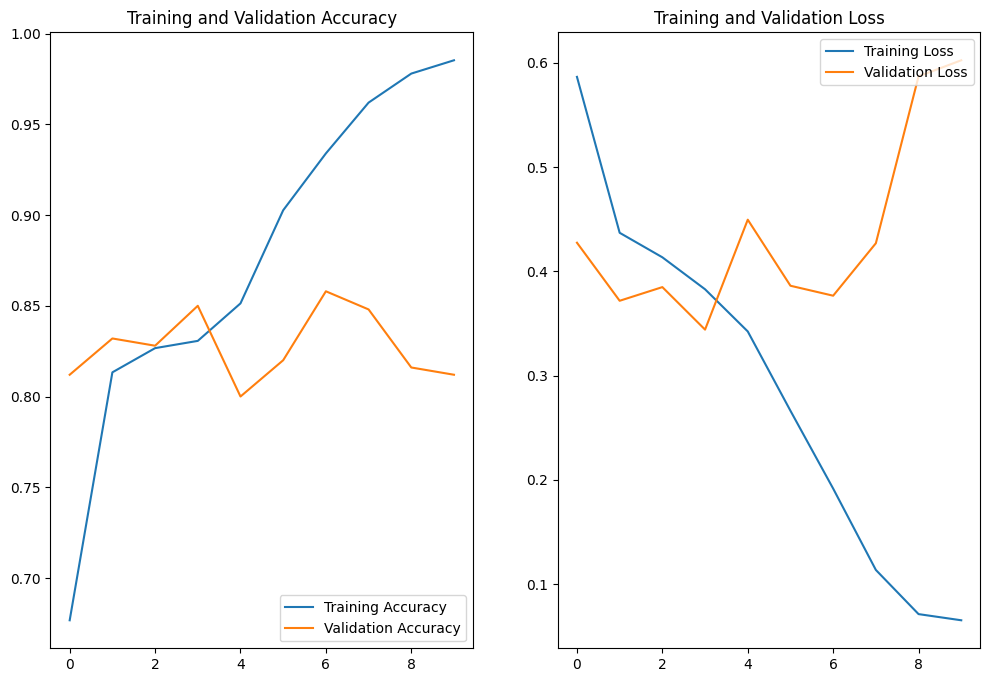

In [24]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Same model, making changes in data and input shape

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5134 - loss: 2.9732
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.5014 - loss: 0.6932
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.4858 - loss: 0.6935


In [ ]:
model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │         602,116 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,806,425 (6.89 MB)

 Trainable params: 602,141 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204,284 (4.59 MB)

Adding extra layers

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.5287 - loss: 6.1938
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6885 - loss: 0.7323
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7028 - loss: 0.9129


In [ ]:
model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │      15,052,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,219,605 (172.50 MB)

 Trainable params: 15,073,201 (57.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,146,404 (115.00 MB)

Again some preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# Get a sample of the training data batch

images,labels = next(train_data)
len(images), len(labels)

(32, 32)

In [ ]:
images[:2], images[0].shape

(array([[[[0.42352945, 0.43137258, 0.34509805],
          [0.3137255 , 0.32941177, 0.2392157 ],
          [0.26666668, 0.28235295, 0.18431373],
          ...,
          [0.42352945, 0.34509805, 0.3803922 ],
          [0.427451  , 0.34901962, 0.39607847],
          [0.45098042, 0.36862746, 0.427451  ]],
 
         [[0.2901961 , 0.30588236, 0.21568629],
          [0.45882356, 0.47450984, 0.37647063],
          [0.2627451 , 0.28627452, 0.18431373],
          ...,
          [0.39607847, 0.34117648, 0.34117648],
          [0.4156863 , 0.36862746, 0.38431376],
          [0.39607847, 0.34901962, 0.3647059 ]],
 
         [[0.3647059 , 0.40000004, 0.29411766],
          [0.38823533, 0.42352945, 0.31764707],
          [0.30588236, 0.34117648, 0.23529413],
          ...,
          [0.34509805, 0.3254902 , 0.30980393],
          [0.30980393, 0.29803923, 0.2784314 ],
          [0.3372549 , 0.3254902 , 0.30588236]],
 
         ...,
 
         [[0.5137255 , 0.5019608 , 0.54509807],
          [0.52156

In [ ]:
labels

array([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential

In [ ]:
model_4 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding='valid',
           activation='relu',
           input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5601 - loss: 2.1331

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.5629 - loss: 2.0958 - val_accuracy: 0.7840 - val_loss: 0.4712
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


AttributeError: 'NoneType' object has no attribute 'items'